### The reason for this notebook is that we have some missing data in both the review counts and nightly price for each month. One potential way to deal with it is to assume a yearly average, but if the two strongly depend on time, we are in bad shape. So let's check that

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 1 let's see how much time varying trend is out there

In [2]:
listings = pd.read_csv('seattle_airbnb_data.dir/listings.csv')
reviews = pd.read_csv('seattle_airbnb_data.dir/reviews.csv')
calendar = pd.read_csv('seattle_airbnb_data.dir/calendar.csv')

In [3]:
def filter_and_combine():
    condition_1 = (listings.room_type == 'Entire home/apt')
    condition_2 = (listings.property_type.isin(['House','Apartment','Townhouse','Condominium','Loft']))
    condition_3 = listings.first_review.apply(lambda x: int(x.split('-')[0])<=2015 if isinstance(x,str) else False)
    condition_4 = listings.last_review.apply(lambda x: int(x.split('-')[0])>=2015 if isinstance(x,str) else False)
    listings_filtered = listings.loc[ condition_1 & condition_2 & condition_3 & condition_4, 
                                     ['id','zipcode','bedrooms','host_since','first_review','last_review']].copy()
    
    # filtered the calendar so it has the same listing_id
    calendar_filtered = calendar[(calendar.available == 't') & 
                                 (calendar.listing_id.isin(listings_filtered.id))].copy()
    calendar_filtered['price'] = calendar_filtered['price'].str.lstrip('\$').replace('\,','',regex=True).astype(float)
    calendar_filtered['month'] = calendar_filtered.date.apply(lambda x: x.split('-')[1])
    month_price = calendar_filtered.groupby(['listing_id','month']).agg({'price':'mean'}).unstack(level=1)
    month_price.columns = month_price.columns.get_level_values(1)
    
    # calculate the relative value in month_price
    mean = month_price.mean(axis=1)
    month_price_relative = month_price.sub(mean, axis=0).div(mean, axis=0)
    
    # deal with review
    reviews['yr'] = reviews.date.apply(lambda x:x.split('-')[0])
    reviews['month'] = reviews.date.apply(lambda x:x.split('-')[1])
    reviews_filtered = reviews[reviews.listing_id.isin(listings_filtered.id)].copy()
    review_counts = reviews_filtered[reviews_filtered.yr=='2015'].groupby(['listing_id','month']).agg({'id':'count'}).unstack(level=1)
    review_counts.columns = review_counts.columns.get_level_values(1)
    
    return listings_filtered, calendar_filtered, month_price, month_price_relative, review_counts

In [4]:
listings_filtered, calendar_filtered, month_price, month_price_relative, review_counts = filter_and_combine()
listings_filtered.shape, calendar_filtered.shape

((2027, 6), (485918, 5))

In [5]:
month_price

month,01,02,03,04,05,06,07,08,09,10,11,12
listing_id,,,,,,,,,,,,
5682,49.636364,52.826087,53.000000,53.000000,56.640000,60.000000,60.000000,60.000000,53.133333,48.580645,48.533333,48.645161
6606,92.666667,92.758621,92.580645,93.333333,92.580645,92.666667,93.225806,92.580645,93.000000,92.903226,92.666667,93.225806
9531,165.000000,NaN,NaN,165.000000,175.000000,185.000000,NaN,NaN,NaN,165.000000,165.000000,165.000000
9534,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,NaN,NaN,125.000000,125.000000,125.000000,125.000000
9596,121.071429,121.379310,121.290323,121.666667,121.290323,121.333333,121.612903,121.290323,121.500000,121.451613,121.333333,121.612903
...,...,...,...,...,...,...,...,...,...,...,...,...
9866984,101.000000,97.105263,97.352941,103.888889,105.000000,103.571429,110.476190,102.741935,104.000000,103.709677,103.000000,104.677419
9908591,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,NaN,NaN,NaN,NaN,NaN,NaN
9924107,114.000000,114.137931,113.870968,115.000000,113.870968,114.000000,114.444444,113.870968,114.500000,114.354839,114.000000,114.838710


In [6]:
month_price_relative

month,01,02,03,04,05,06,07,08,09,10,11,12
listing_id,,,,,,,,,,,,
5682,-0.075092,-0.015655,-0.012415,-0.012415,0.055412,0.118021,0.118021,0.118021,-0.009930,-0.094763,-0.095645,-0.093561
6606,-0.001964,-0.000974,-0.002891,0.005216,-0.002891,-0.001964,0.004058,-0.002891,0.001626,0.000583,-0.001964,0.004058
9531,-0.025316,NaN,NaN,-0.025316,0.033755,0.092827,NaN,NaN,NaN,-0.025316,-0.025316,-0.025316
9534,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000
9596,-0.002729,-0.000193,-0.000926,0.002174,-0.000926,-0.000571,0.001731,-0.000926,0.000801,0.000403,-0.000571,0.001731
...,...,...,...,...,...,...,...,...,...,...,...,...
9866984,-0.019833,-0.057630,-0.055226,0.008203,0.018986,0.005122,0.072130,-0.002928,0.009281,0.006464,-0.000424,0.015855
9908591,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
9924107,-0.002107,-0.000900,-0.003237,0.006646,-0.003237,-0.002107,0.001783,-0.003237,0.002269,0.000999,-0.002107,0.005234


In [7]:
review_counts

month,01,02,03,04,05,06,07,08,09,10,11,12
listing_id,,,,,,,,,,,,
5682,3.0,4.0,7.0,5.0,5.0,4.0,5.0,6.0,6.0,7.0,6.0,3.0
6606,NaN,NaN,NaN,1.0,1.0,2.0,5.0,3.0,3.0,NaN,2.0,1.0
9531,NaN,NaN,NaN,2.0,NaN,3.0,2.0,NaN,3.0,3.0,1.0,1.0
9534,NaN,NaN,NaN,NaN,NaN,2.0,2.0,3.0,NaN,1.0,NaN,NaN
9596,NaN,NaN,NaN,NaN,1.0,3.0,4.0,1.0,3.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
9908591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
9924107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
9929059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0


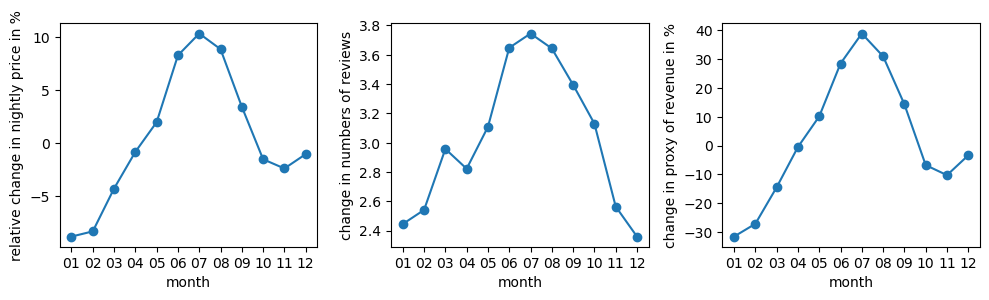

In [8]:
price_mean = month_price_relative.mean(axis=0)
review_mean = review_counts.mean(axis=0)
proxy_mean = (month_price_relative * review_counts).mean(axis=0)
fig = plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.plot(price_mean*100,'o-');plt.xlabel('month');plt.ylabel('relative change in nightly price in %')
plt.subplot(1,3,2)
plt.plot(review_mean,'o-');plt.xlabel('month');plt.ylabel('change in numbers of reviews')
plt.subplot(1,3,3)
plt.plot(proxy_mean*100,'o-');plt.xlabel('month');plt.ylabel('change in proxy of revenue in %')
fig.tight_layout()
plt.show()

In [9]:
4/0.5, 3/0.75

(8.0, 4.0)

In [10]:
(8-6)/6

0.3333333333333333

### the uncertainty comes from average length of stay and percentage of reviewer that would leave comments is also about +-30%, the proxy for revenue (price per night * # of reviews) also varies at this level; this means we need to consider the time varying behaviour in our calculations

### 2 how many data are missing and how to deal with them?

#### 2.1 missing data in calendar (i.e. price)

In [11]:
tmp = calendar_filtered.groupby(['listing_id','month']).agg({'date':'count'}).unstack(level=1)
tmp

date                                                              \
month         01    02    03    04    05    06    07    08    09    10    11   
listing_id                                                                     
5682        11.0  23.0  11.0  25.0  25.0  30.0  31.0  31.0  30.0  31.0  30.0   
6606        30.0  29.0  31.0  30.0  31.0  30.0  31.0  31.0  30.0  31.0  30.0   
9531         2.0   NaN   NaN  30.0  31.0  25.0   NaN   NaN   NaN  31.0  30.0   
9534         2.0  21.0  26.0  30.0  31.0  30.0   NaN   NaN  30.0  31.0  30.0   
9596        28.0  29.0  31.0  30.0  31.0  30.0  31.0  31.0  30.0  31.0  30.0   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
9866984      5.0  19.0  17.0  27.0  18.0  28.0  21.0  31.0  30.0  31.0  30.0   
9908591     21.0  18.0  14.0  19.0  28.0   4.0   NaN   NaN   NaN   NaN   NaN   
9924107     30.0  29.0  31.0  30.0  31.0  30.0  27.0  31.0  30.0  31.0  30.0   
9929059     24.0  29.0  31.0   1.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
9957555     22.0  29.0  31.0   1.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

                  
month         12  
listing_id        
5682        31.0  
6606        31.0  
9531        31.0  
9534        31.0  
9596        31.0  
...          ...  
9866984     31.0  
9908591      NaN  
9924107     31.0  
9929059     20.0  
9957555      NaN  

[1973 rows x 12 columns]

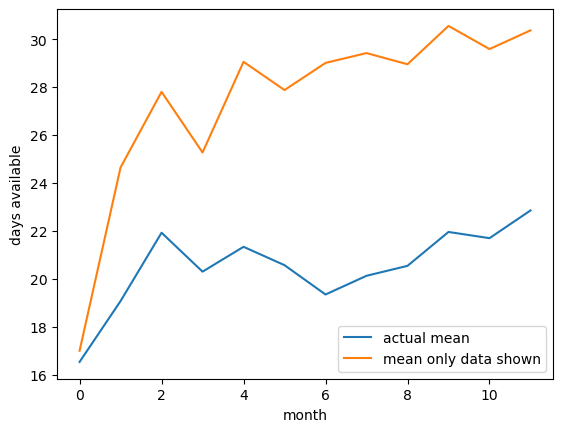

In [12]:
plt.plot(tmp.sum(axis=0).values/tmp.shape[0], label='actual mean')
plt.plot(tmp.mean(axis=0).values, label='mean only data shown')
plt.xlabel('month'); plt.ylabel('days available');
plt.legend();

#### mmm, it's not sayting too much; it just means if a certain month is available, it is likely to be available for the entire month, but it doesn't say too much about whether it's available or not to start with; the actual average suggests only ~70% of dates are available; the dip in january though is likely because some are already booked, so not available anymore

In [13]:
np.isnan(month_price.values).sum(), month_price.isna().sum().sum()

(5768, 5768)

In [14]:
month_price.isna().sum().sum() / (month_price.shape[0] * month_price.shape[1])

0.24362223348538606

In [15]:
month_price_relative.isna().sum().sum() / (month_price_relative.shape[0] * month_price_relative.shape[1])

0.24362223348538606

#### there isn't that many nan and the monthly price means something, i am leaning towards imputing this matrix

#### 2.2 missing data in review

In [16]:
listings_filtered

,id,zipcode,bedrooms,host_since,first_review,last_review
0,241032,98119,1.0,2011-08-11,2011-11-01,2016-01-02
1,953595,98119,1.0,2013-02-21,2013-08-19,2015-12-29
2,3308979,98119,5.0,2014-06-12,2014-07-30,2015-09-03
4,278830,98119,3.0,2011-11-29,2012-07-10,2015-10-24
9,2493658,98119,1.0,2013-02-21,2014-04-27,2015-12-20
...,...,...,...,...,...,...
3810,262764,98103,2.0,2011-11-07,2015-10-01,2015-12-27
3811,8578490,98103,1.0,2014-02-01,2015-10-01,2015-10-16
3812,3383329,98107,1.0,2012-09-01,2014-07-08,2015-12-29
3813,8101950,98107,3.0,2015-04-13,2015-09-27,2015-09-27


In [17]:
def get_start_month(x):
    yr, month, _ = x.split('-')
    if yr < '2015':
        return '01'
    elif yr > '2015':
        return '13'
    else:
        return month

def get_last_month(x):
    yr, month, _ = x.split('-')
    if yr < '2015':
        return '00'
    elif yr > '2015':
        return '12'
    else:
        return month    

In [18]:
listings_filtered['host_since_month'] = listings_filtered.host_since.apply(get_start_month)
listings_filtered['first_review_month'] = listings_filtered.first_review.apply(get_start_month)
listings_filtered['last_review_month'] = listings_filtered.last_review.apply(get_last_month)

In [19]:
listings_filtered

,id,zipcode,bedrooms,host_since,first_review,last_review,host_since_month,first_review_month,last_review_month
0,241032,98119,1.0,2011-08-11,2011-11-01,2016-01-02,01,01,12
1,953595,98119,1.0,2013-02-21,2013-08-19,2015-12-29,01,01,12
2,3308979,98119,5.0,2014-06-12,2014-07-30,2015-09-03,01,01,09
4,278830,98119,3.0,2011-11-29,2012-07-10,2015-10-24,01,01,10
9,2493658,98119,1.0,2013-02-21,2014-04-27,2015-12-20,01,01,12
...,...,...,...,...,...,...,...,...,...
3810,262764,98103,2.0,2011-11-07,2015-10-01,2015-12-27,01,10,12
3811,8578490,98103,1.0,2014-02-01,2015-10-01,2015-10-16,01,10,10
3812,3383329,98107,1.0,2012-09-01,2014-07-08,2015-12-29,01,01,12
3813,8101950,98107,3.0,2015-04-13,2015-09-27,2015-09-27,04,09,09


<AxesSubplot:>

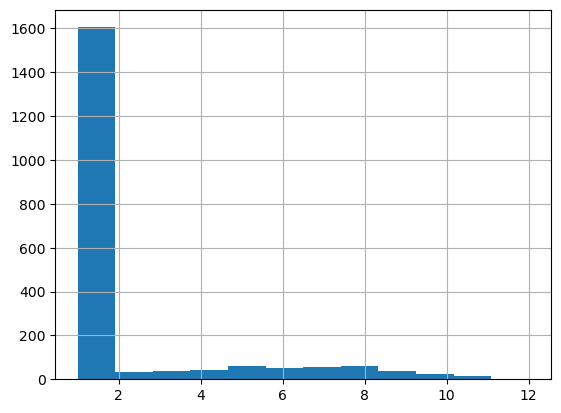

In [20]:
listings_filtered.host_since_month.astype(int).hist(bins=12)

In [21]:
listings_filtered['months_between_reviews'] = \
      listings_filtered.last_review_month.astype(int) -\
      listings_filtered.first_review_month.astype(int)

<AxesSubplot:>

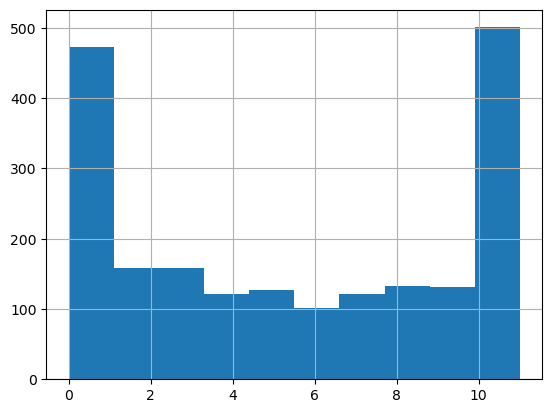

In [22]:
listings_filtered.months_between_reviews.hist()

<AxesSubplot:>

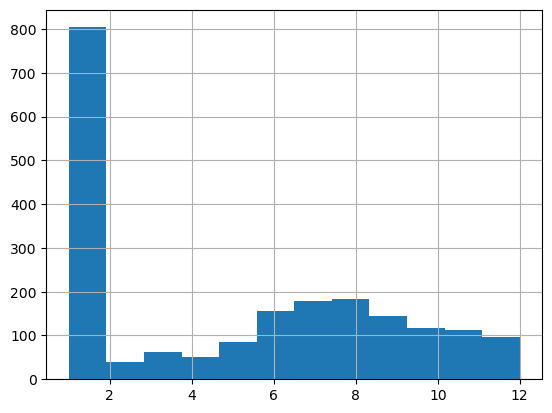

In [23]:
listings_filtered.first_review_month.astype(int).hist(bins=12)

#### obs (a): so looks like majority of host was already hosting since January, plus, we do see a lot of reviews started coming in in january. These two means many hosts are indeed "working" for the entire year. The bump in summar is likely real and reflects the fact that there are more tourists in the summer. However, the histogram of month bewteen the first and last reviews looks bimodal and has a lot of 0s, which implies some listings simply do not have a lot of reviews

In [24]:
review_counts

month,01,02,03,04,05,06,07,08,09,10,11,12
listing_id,,,,,,,,,,,,
5682,3.0,4.0,7.0,5.0,5.0,4.0,5.0,6.0,6.0,7.0,6.0,3.0
6606,NaN,NaN,NaN,1.0,1.0,2.0,5.0,3.0,3.0,NaN,2.0,1.0
9531,NaN,NaN,NaN,2.0,NaN,3.0,2.0,NaN,3.0,3.0,1.0,1.0
9534,NaN,NaN,NaN,NaN,NaN,2.0,2.0,3.0,NaN,1.0,NaN,NaN
9596,NaN,NaN,NaN,NaN,1.0,3.0,4.0,1.0,3.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
9908591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
9924107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
9929059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0


In [25]:
na_counts = review_counts.isna().sum(axis=1)
na_counts

listing_id
5682        0
6606        4
9531        5
9534        8
9596        7
           ..
9908591    11
9924107    11
9929059    11
9939359    11
9957555    11
Length: 2027, dtype: int64

In [26]:
na_counts.sum() / (review_counts.shape[0] * review_counts.shape[1])

0.5821822068738695

#### this is a lot of nan!

<AxesSubplot:xlabel='mean_counts', ylabel='na_counts'>

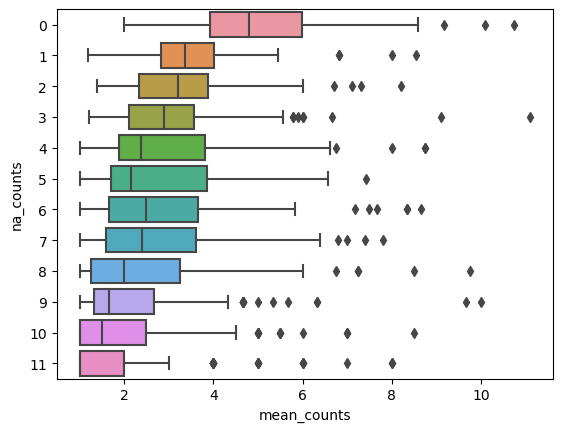

In [27]:
tmp = pd.DataFrame()
tmp['mean_counts'] = review_counts.mean(axis=1).values
tmp['na_counts'] = na_counts.values.astype('str')
sns.boxplot(data=tmp, y='na_counts', x='mean_counts', order=[str(i) for i in range(12)])

#### obs (b): the na_counts has some dependence on the mean_counts, which means hosts with fewer reviews tend to have more nans. 

#### so combining obs(a) and obs(b), i am leaning towards filling nan as 0 here. Keep in mind that this may underestimate the revenue though as compared to filling with mean/median.